# Set up the Google Colab notebook's environment (run this first!):

In [1]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo apt install python3-pip libfftw3-dev libgsl-dev
!pip install numpy scipy matplotlib lisa-data-challenge chainconsumer eryn astropy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3 libgsl23
  libgslcblas0 python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  libfftw3-doc gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
  python-setuptools-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3 libfftw3-single3
  libgsl-dev libgsl23 libgslcblas0 python-pip-whl python3-pip
  python3-setuptools python3-wheel
0 upgraded, 12 newly installed, 0 to remove and 13 not upgraded.
Need to get 8,373 kB of archives.
After this operation, 37.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu1 [313 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu1 [673 kB]
Get:3 http:/

# LISA Tutorial

This notebook shows how to :
- Create galactic binary waveforms using FastGB
- Create noise that resembles lisa noise
- Use an Eryn, M. ᓚᘏᗢs mcmc, to find the binary parameters.


First, we'll import the necessary libraries

In [2]:
#Boiler plate python libraries
import matplotlib.pyplot as plt
import numpy as np
#lisa data challenge stuff
import ldc
from ldc.waveform.fastGB import FastGB
from ldc.lisa.noise import AnalyticNoise
from ldc.lisa.orbits import Orbits
from ldc.common.series import TDI
# M. ᓚᘏᗢs mcmc
import eryn
from eryn.prior import uniform_dist, ProbDistContainer
# units from astropy
from astropy import units as u

## Data Generation

First, we'll create a source waveform using FastGB (included in the LISA Data Challenge tools)

In [3]:
# We will first create a source by specifying galactic binary parameters in a dictionary
src = {'Amplitude': 4.532253297280512e-23,
 'EclipticLatitude': -0.6089326756389446,
 'EclipticLongitude': 4.363864825569529,
 'Frequency': 0.010068091384645718,
 'FrequencyDerivative': 1.7937336822447453e-15,
 'Inclination': 0.6741257207267898,
 'InitialPhase': 5.4809303996782806,
 'Polarization': 0.43040349955174967}

# We will then specify the LISA constellation's orbits parameters (these are the same as the default)
orbits = Orbits.type(dict({'orbit_type':'analytic', 'nominal_arm_length':2.5e6*u.km,
                           "initial_position": 0*u.rad, "initial_rotation": 0*u.rad}))

# the delta t for data (in s)
dt = 10

# Then specify the time we have had lisa in space, in this case 3 months, to start
t_max = (int( (93*u.day).to(u.s) / u.s ) // dt) * dt


GB = FastGB(delta_t=dt, T=t_max, orbits=orbits)

Simulated LISA data is convenient to work with in the AET channels. Here we will generate the waveform in XYZ and convert it to AET

In [4]:
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TDI, FrequencySeries, TimeSeries
import scipy

def get_sources_AET(srcs,t_max=t_max,dt=dt):
  for (i,src) in enumerate(srcs):
    # h+, hx
    GW = HpHc.type("debug", "GB", "TD_fdot"); GW.set_param(src)
    p = ProjectedStrain(orbits)
    yArm = p.arm_response(0, t_max, dt, [GW])

    X = TimeSeries(p.compute_tdi_x(np.arange(0, t_max, dt)), dt=dt, t0=0)
    Y = TimeSeries(p.compute_tdi_y(np.arange(0, t_max, dt)), dt=dt, t0=0)
    Z = TimeSeries(p.compute_tdi_z(np.arange(0, t_max, dt)), dt=dt, t0=0)
    # should do PSD instead
    if i == 0:
      Xt = X.copy(); Yt = Y.copy(); Zt = Z.copy();
    else:
      Xt += X; Yt += Y; Zt += Z;


  Xf = Xt.ts.fft()
  Yf = Yt.ts.fft()
  Zf = Zt.ts.fft()

  AET_data_fd = TDI(dict(zip(["X", "Y", "Z"], [Xf,Yf,Zf])))
  AET_data_fd.XYZ2AET()

  f = np.fft.rfftfreq(t_max//dt,dt)
  return f, AET_data_fd

In [5]:
f, AET_data_fd = get_sources_AET([src])

Let's look at the synthesized waveform:

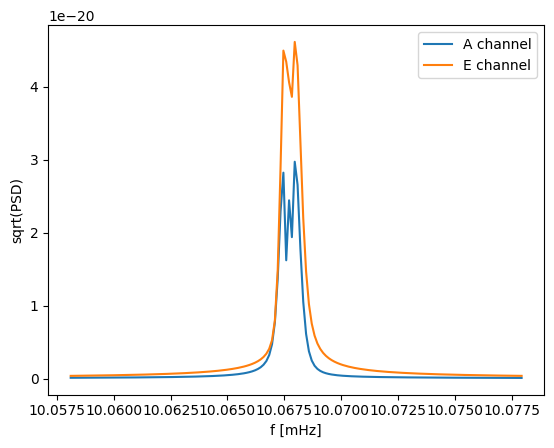

In [6]:
# choose a small window around the peak frequency
fmin = src["Frequency"]-1e-5
fmax = src["Frequency"]+1e-5
df = (AET_data_fd.f[1] - AET_data_fd.f[0]).to_numpy()
emin = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmin))
emax = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmax))
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.A[emin:emax])*np.sqrt(4*df),label='A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.E[emin:emax])*np.sqrt(4*df),label='E channel')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

## Noise Generation

Here we'll generate some noise matching the Sangria LDC.

If we know the theoretical noise PSD, we can make a realization of the noise with
$$
\text{FFT}_a = \sqrt{\frac{\text{PSD}_a}{2}} (x+ i y)
$$
where $x$ and $y$ are independent unit random normals, and $a$ labels the frequency.

/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in true_divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in true_divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in multiply
  s_oms_nu = self.psd_oms_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lis

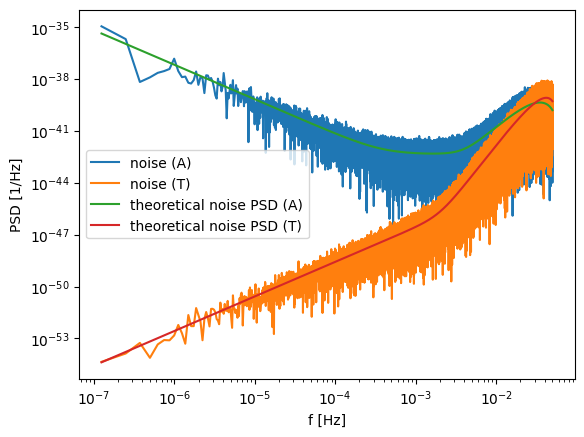

In [16]:
noise = AnalyticNoise(f,model="sangria")

# theoretical noise PSD
noise_psd_A = noise.psd(option='A',freq=f)
noise_psd_E = noise.psd(option='E',freq=f)
noise_psd_T = noise.psd(option='T',freq=f)

def randc(r):
    return r/np.sqrt(2)*(np.random.randn(*r.shape) + 1j*np.random.randn(*r.shape))

noise_fft = randc(np.sqrt(np.array([noise_psd_A,noise_psd_E,noise_psd_T])))


plt.loglog(f[f>0],np.abs(noise_fft[0][f>0])**2,label='noise (A)')
plt.loglog(f[f>0],np.abs(noise_fft[2][f>0])**2,label='noise (T)')
plt.loglog(f[f>0],noise_psd_A[f>0],label='theoretical noise PSD (A)')
plt.loglog(f[f>0],noise_psd_T[f>0],label='theoretical noise PSD (T)')
plt.ylabel("PSD [1/Hz]")
plt.xlabel("f [Hz]")
plt.legend()
plt.show()

The full data is now given by the noise plus our injection

In [8]:
data_A = AET_data_fd.A.to_numpy()*np.sqrt(4*df) + noise_fft[0]
data_E = AET_data_fd.E.to_numpy()*np.sqrt(4*df) + noise_fft[1]
data_T = AET_data_fd.T.to_numpy()*np.sqrt(4*df) + noise_fft[2]

In [9]:
s_a = noise.psd(freq=f, option='A')
snr_a = (4.0*df) * np.sum(np.abs(AET_data_fd.A)[:]**2/s_a)
print("Computed SNR is " + str(np.sqrt(float(snr_a))))

Computed SNR is 16.876517918589606


/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in true_divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in true_divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in multiply
  s_oms_nu = self.psd_oms_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lis

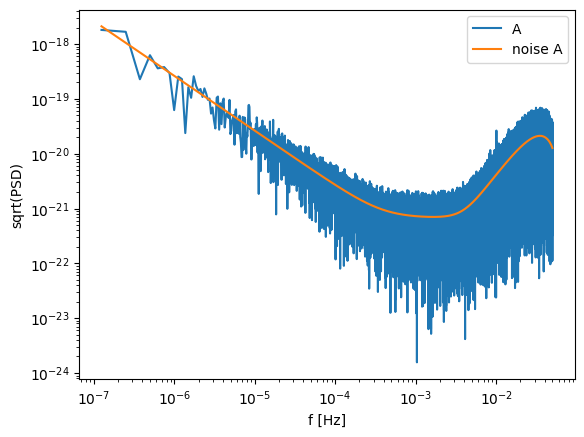

In [10]:
plt.loglog(f,np.abs(data_A),label='A')
plt.loglog(f,np.sqrt(noise.psd(freq=f, option='A')),label='noise A')
plt.ylabel("sqrt(PSD)")
plt.xlabel("f [Hz]")
plt.legend()
plt.show()

The GB signal is totally buried in the noise! But we can recover it

If we had done a periodogram on the data, the GB signal would be more visible, since a periodogram averages out noise

# Sampling

For the sampling, we will use an MCMC package called `eryn`.

You can read more about MCMCs in general and `eryn` in particular in the [`eryn` tutorial](https://github.com/mikekatz04/Eryn/blob/main/examples/Eryn_tutorial.ipynb).

Add more MCMC details here???

In [17]:
# log prior
fr_my_min = 3e-3
fr_my_max = 3e-2
priors = ProbDistContainer(
    {
        0: uniform_dist(-24.0,-20.0), # log10 amplitude
        1: uniform_dist(fr_my_min, fr_my_max),   ### fr in Hz
        2: uniform_dist(-17.0, -14.0),  ### log10 fdot
        3: uniform_dist(-1.0, 1.0), ###sin bet
        4: uniform_dist(0.0, 2.0*np.pi), ##lam
        5: uniform_dist(-1.0, 1.0), ## cos_iota
        6: uniform_dist(0.0, 2.0*np.pi), #psi
        7: uniform_dist(0.0, 2.0*np.pi), #phi0
    }
)

In [18]:
def as_gb_param(pp):
    """ switch from search parameterization to fastGB parameterization
    """
    l_Amp, mf0, l_fdot, sin_bet, lam, cos_iota, psi, phi0 = pp
    iota = np.arccos(cos_iota)
    beta = np.arcsin(sin_bet)
    amp = 10.0**l_Amp
    f0 = mf0
    fdot = 10.0**l_fdot
    return {'Frequency':f0, 'FrequencyDerivative':fdot, 'EclipticLatitude':beta, 'EclipticLongitude':lam,
            'Amplitude':amp, 'Inclination':iota, 'Polarization':psi, 'InitialPhase':phi0}

Next we'll define the Likelihood:

In [19]:
def likelihood(pars,Nsrc=1,data=[data_A,data_E,data_T],GB=GB,plotIt=False,noise=noise):
    """ pars is Nsrc x ndim
    """
    pars.shape= (Nsrc,len(pars)//Nsrc)
    for ind in range(Nsrc):
        pp = pars[ind, :]
        pGB = as_gb_param(pp)
        if ind == 0:
            Xf_i, Yf_i, Zf_i = GB.get_fd_tdixyz(template=pGB, oversample=4)
            kmin = int(Xf_i.attrs["kmin"])
            df = (Xf_i.f[1]-Xf_i.f[0]).values
            Xf, Yf, Zf = Xf_i.copy(), Yf_i.copy(), Zf_i.copy()
        else:
            Xf_i, Yf_i, Zf_i = GB.get_fd_tdixyz(template=pGB, oversample=4, freqs=Xf.f)
            Xf = Xf + Xf_i ; Yf = Yf + Yf_i ; Zf = Zf + Zf_i

    AET = TDI(dict(zip(["X", "Y", "Z"], [Xf, Yf, Zf])))
    AET.XYZ2AET()

    SA = noise.psd(freq=AET.f, option='A')
    #kmin = int(AET.A.attrs["kmin"])
    At = data[0][kmin:kmin+len(AET.A.values)]
    Et = data[1][kmin:kmin+len(AET.A.values)]
    AET_A = AET.A.values*np.sqrt(4*df)
    AET_E = AET.E.values*np.sqrt(4*df)

    SNR2 = np.sum( np.real(At * np.conjugate(AET_A) +\
                           Et * np.conjugate(AET_E)) /SA )
    hh = np.sum((np.absolute(AET_A)**2 + np.absolute(AET_E)**2) /SA)

    if plotIt:
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,8))
        ax[0].plot(AET.f, np.abs(At), label='data')
        ax[0].plot(AET.f, np.abs(AET_A), label='model',linestyle='--')
        ax[1].plot(AET.f, np.abs(Et), label='data')
        ax[1].plot(AET.f, np.abs(AET_E), label='model',linestyle='--')

        #ax[1].loglog(f,noise_psd_A)
        #ax[1].loglog(AET.f,SA,label="noise",linestyle='--')
        for i in range(2):
            ax[i].set_xlim([min(AET.f), max(AET.f)])
        #    ax[i].set_ylim([1.e-42, 1.5e-37])
        #    ax[i].legend();
        plt.show()
        #print(aaaa)

    loglik = ( SNR2 - 0.5 * hh )
    return (loglik.values)

In [20]:
inj=np.array([np.log10(src['Amplitude']),
            src['Frequency'],
            np.log10(src['FrequencyDerivative']),
            np.sin(src['EclipticLatitude']),
            src['EclipticLongitude'],
            np.cos(src['Inclination']),
            src['Polarization'],
            src['InitialPhase']])
likelihood(inj.copy())

array(573.45920375)

In [21]:
from eryn.ensemble import EnsembleSampler
ndim = len(src)
nwalkers=3*ndim
ntemps = 5
nchainlength= 10000
nburn=500

download_results = True

if not download_results:
  theta0 = np.array([[np.random.randn(ndim)*1e-8 + inj for _ in range(nwalkers)] for _ in range(ntemps)])

  print(inj)
  print(theta0.shape)
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool)
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
      tau=sampler.get_autocorr_time()['model_0']
      print(tau)
      # thin chains to make sure we have independent samples
      chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
      np.save("./chains11.npy",chains)
else:
  !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y" -O chains11.npy
  chains = np.load("./chains11.npy")

--2023-06-26 16:33:19--  https://drive.google.com/uc?export=download&id=1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y
Resolving drive.google.com (drive.google.com)... 64.233.182.138, 64.233.182.139, 64.233.182.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.182.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/slsoen9uohl2skmqob4hl92e21js6qca/1687797150000/05374547873163544695/*/1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y?e=download&uuid=9b7e3efa-b3d2-4c79-af71-3b83d6ccd362 [following]
--2023-06-26 16:33:22--  https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/slsoen9uohl2skmqob4hl92e21js6qca/1687797150000/05374547873163544695/*/1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y?e=download&uuid=9b7e3efa-b3d2-4c79-af71-3b83d6ccd362
Resolving doc-00-18-docs.googleusercontent.com (doc-00-18-docs.googleusercontent.com)... 172.253.119.132, 2607

The autocorrelation times (last line) measure how well our sampler is doing, and what percentage of samples we can keep

$\tau \rightarrow 1$ is best

In [22]:
chains_burnt=chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

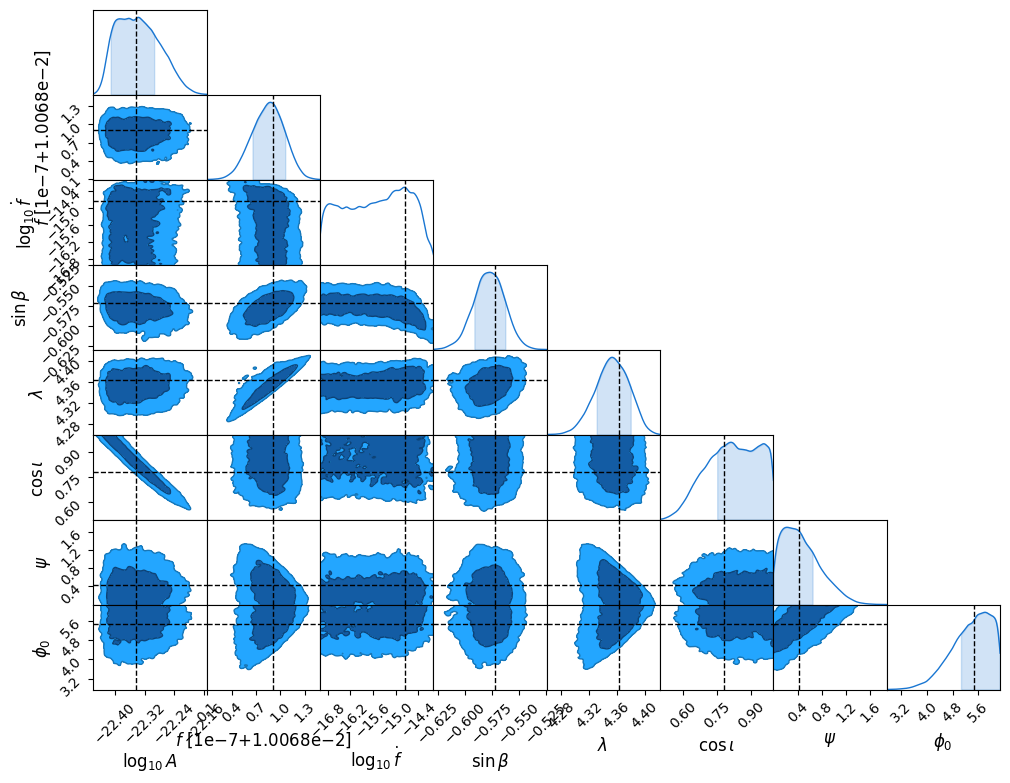

In [23]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']


truths = inj.flatten()
labels_final = labels
c.add_chain(chains_burnt,parameters=labels_final)
fig1 = c.plotter.plot(truth=truths, parameters = labels_final,figsize=(16*2/3,12*2/3))

We recovered the source!

Diagnostic MCMC plots

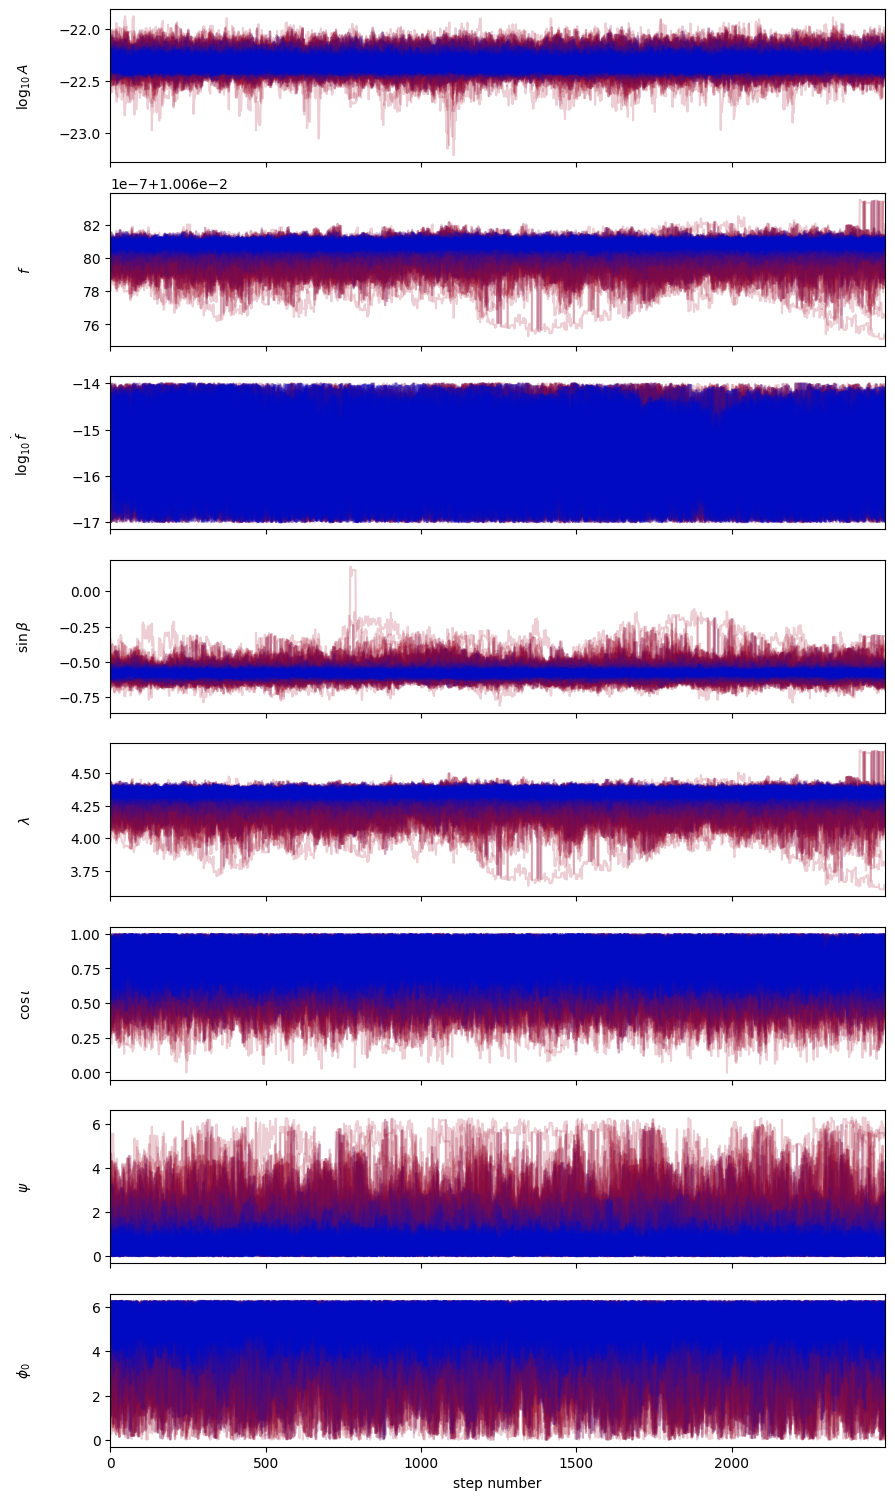

In [24]:
def color_interp(rgb_0,rgb_f,steps):
    r,g,b = rgb_0
    re,ge,be = rgb_f
    return ['#{:02X}{:02X}{:02X}'.format(int((re-r)/steps*i+r),int((ge-g)/steps*i+g),int((be-b)/steps*i+b)) for i in range(steps)]
ndim = chains.shape[-1]
fig, axes = plt.subplots(ndim, figsize=(10, 7/3*(ndim)), sharex=True)
#keylist=list(priors.keys())
#labels = keylist
#ntemps = self.ntemps
#nwalkers = self.nwalkers
csteps = color_interp((0,10,200),(200,10,0),ntemps)
for j in range(ndim):
    ax = axes[j]
    ax.set_xlim(0, chains.shape[0])
    ax.set_ylabel(labels_final[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    for t in reversed(range(ntemps)):
        for k in range(nwalkers):
            ax.plot(chains[:,t,k,0,j],c=csteps[t],alpha=0.2)
#ll = sampler.get_log_like()
#for k in range(nwalkers):
#    axes[-1].plot(ll[:,0,k])
#axes[-1].set_ylabel("log pos (T=1)")
#axes[-1].yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

# Now let's try our own mini "global fit" with two sources

In [25]:
# the first source is the same as the last one
src1 = {'Amplitude': 4.532253297280512e-23,
 'EclipticLatitude': -0.6089326756389446,
 'EclipticLongitude': 4.363864825569529,
 'Frequency': 0.010068091384645718,
 'FrequencyDerivative': 1.7937336822447453e-15,
 'Inclination': 0.6741257207267898,
 'InitialPhase': 5.4809303996782806,
 'Polarization': 0.43040349955174967}
# the second will be identical, but in another location on the sky
src2 = src1.copy()
src2["EclipticLatitude"] += -np.pi/4
src2["EclipticLongitude"] = np.pi/4
src2["EclipticLongitude"] %= (2*np.pi)
src2["EclipticLatitude"]  %= (np.pi/2)

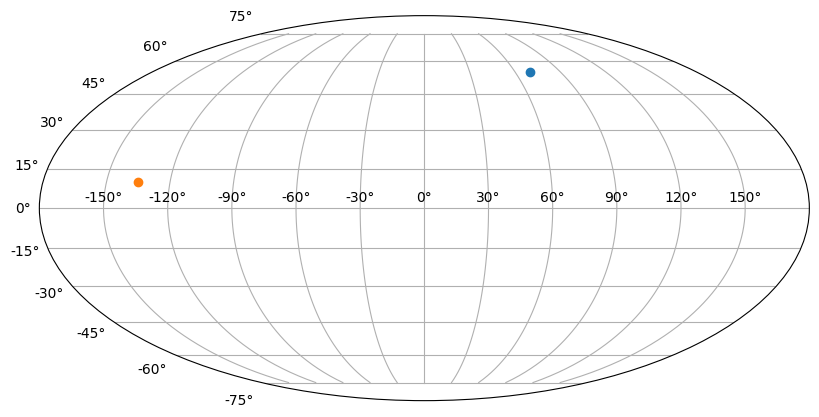

In [26]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(src1["EclipticLongitude"]-np.pi,src1["EclipticLatitude"]%(np.pi/2))
ax.scatter(src2["EclipticLongitude"]-np.pi,src2["EclipticLatitude"]%(np.pi/2))
plt.show()

## First with three months of data

In [27]:
f, AET_data_fd = get_sources_AET([src1,src2])
f, AET_data_fd1 = get_sources_AET([src1])
f, AET_data_fd2 = get_sources_AET([src2])
df = f[1] - f[0]
data_A = AET_data_fd.A.to_numpy()*np.sqrt(4*df) + noise_fft[0]
data_E = AET_data_fd.E.to_numpy()*np.sqrt(4*df) + noise_fft[1]
data_T = AET_data_fd.T.to_numpy()*np.sqrt(4*df) + noise_fft[2]

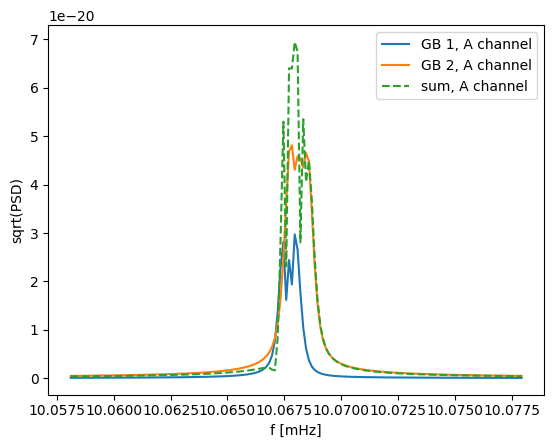

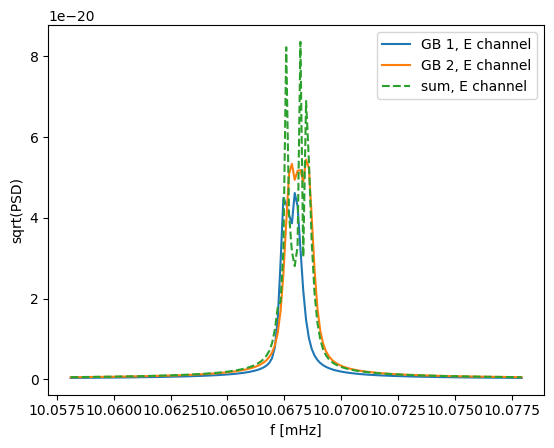

In [28]:
# choose a small window around the peak frequency
fmin = src1["Frequency"]-1e-5
fmax = src1["Frequency"]+1e-5
df = AET_data_fd.f[1] - AET_data_fd.f[0]
emin = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmin))
emax = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmax))
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.A[emin:emax])*np.sqrt(4*df),label='GB 1, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.A[emin:emax])*np.sqrt(4*df),label='GB 2, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.A[emin:emax])*np.sqrt(4*df),label='sum, A channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.E[emin:emax])*np.sqrt(4*df),label='GB 1, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.E[emin:emax])*np.sqrt(4*df),label='GB 2, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.E[emin:emax])*np.sqrt(4*df),label='sum, E channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

In [29]:
inj2 = np.array([np.log10(src1['Amplitude']),
            src1['Frequency'],
            np.log10(src1['FrequencyDerivative']),
            np.sin(src1['EclipticLatitude']),
            src1['EclipticLongitude'],
            np.cos(src1['Inclination']),
            src1['Polarization'],
            src1['InitialPhase'],
            np.log10(src2['Amplitude']),
            src2['Frequency'],
            np.log10(src2['FrequencyDerivative']),
            np.sin(src2['EclipticLatitude']),
            src2['EclipticLongitude'],
            np.cos(src2['Inclination']),
            src2['Polarization'],
            src2['InitialPhase']])
likelihood(inj2.copy(),Nsrc=2,data=[data_A,data_E,data_T])

array(1913.70303425)

In [30]:
fr_my_min = 3e-3
fr_my_max = 3e-2
priors = ProbDistContainer(
    {
        0: uniform_dist(-24.0,-20.0), # log10 amplitude
        1: uniform_dist(fr_my_min, fr_my_max),   ### fr in Hz
        2: uniform_dist(-17.0, -14.0),  ### log10 fdot
        3: uniform_dist(-1.0, 1.0), ###sin bet
        4: uniform_dist(0.0, 2.0*np.pi), ##lam
        5: uniform_dist(-1.0, 1.0), ## cos_iota
        6: uniform_dist(0.0, 2.0*np.pi), #psi
        7: uniform_dist(0.0, 2.0*np.pi), #phi0
        8: uniform_dist(-24.0,-20.0), # log10 amplitude
        9: uniform_dist(fr_my_min, fr_my_max),   ### fr in Hz
        10: uniform_dist(-17.0, -14.0),  ### log10 fdot
        11: uniform_dist(-1.0, 1.0), ###sin bet
        12: uniform_dist(0.0, 2.0*np.pi), ##lam
        13: uniform_dist(-1.0, 1.0), ## cos_iota
        14: uniform_dist(0.0, 2.0*np.pi), #psi
        15: uniform_dist(0.0, 2.0*np.pi), #phi0
    }
)

In [31]:
from eryn.ensemble import EnsembleSampler
ndim = len(inj2)
nwalkers=3*ndim
ntemps = 5
nchainlength= 10000
nburn=500

# start in a small ball around the right answer
# to initialize blind searches, could use a peak detection
theta0 = np.array([[np.random.randn(ndim)*1e-8 + inj2 for _ in range(nwalkers)] for _ in range(ntemps)])
download_results = True

if not download_results:
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool,args=(2,))
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
  tau=sampler.get_autocorr_time()['model_0']
  print(tau)
  # thin chains to make sure we have independent samples
  chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
  np.save("./chains3_22.npy",chains)
else:
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt" -O chains3_22.npy && rm -rf /tmp/cookies.txt
  chains = np.load("./chains3_22.npy")

--2023-06-26 16:36:05--  https://docs.google.com/uc?export=download&confirm=&id=1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt
Resolving docs.google.com (docs.google.com)... 172.217.214.100, 172.217.214.138, 172.217.214.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fn6adrvh0f9epk0j179htun3bm1ik4qo/1687797300000/05374547873163544695/*/1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt?e=download&uuid=e28312ef-5835-4d31-a0c0-b06b5a0c7d22 [following]
--2023-06-26 16:36:09--  https://doc-0s-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fn6adrvh0f9epk0j179htun3bm1ik4qo/1687797300000/05374547873163544695/*/1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt?e=download&uuid=e28312ef-5835-4d31-a0c0-b06b5a0c7d22
Resolving doc-0s-18-docs.googleusercontent.com (doc-0s-18-docs.googleusercontent.com)... 172.253.119.1

In [32]:
chains_burnt = chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

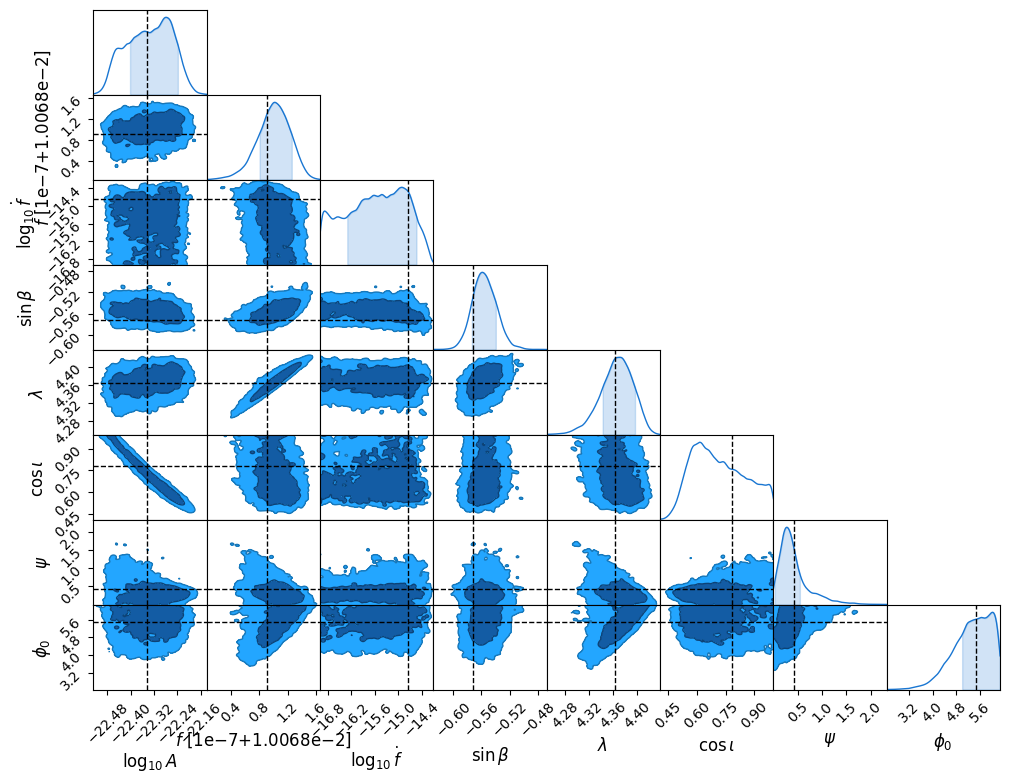

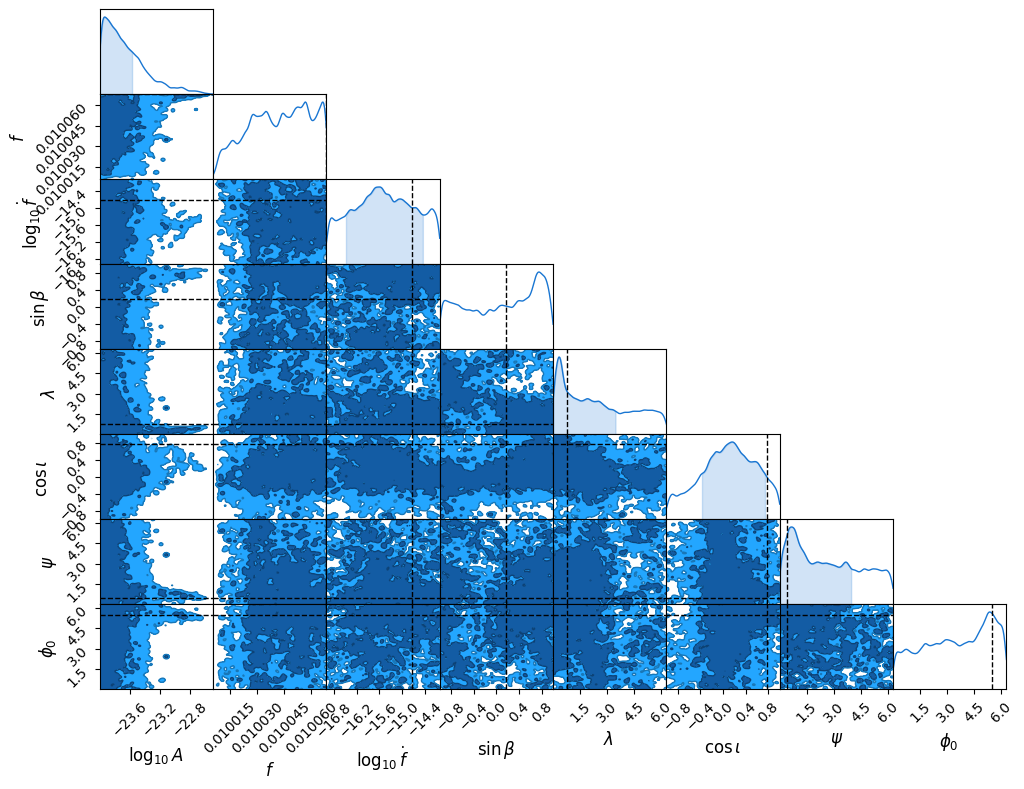

In [33]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']
truths = inj2
labels_final = labels
c.add_chain(chains_burnt[:,:8],parameters=labels_final,name='GB 1')
fig1 = c.plotter.plot(truth=truths[:8], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()
c = ChainConsumer()
c.add_chain(chains_burnt[:,8:],parameters=labels_final,name='GB 2')
fig2 = c.plotter.plot(truth=truths[8:], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()

So we were unable to disentangle the two sources! GB number 1 was recovered well, but not the second one

# Retry two sources with more data!

In [34]:
dt = 10
t_max = (int( (365*u.day).to(u.s) / u.s ) // dt) * dt

GB = FastGB(delta_t=dt, T=t_max, orbits=orbits)

In [35]:
f, AET_data_fd = get_sources_AET([src1,src2],t_max=t_max,dt=dt)
f, AET_data_fd1 = get_sources_AET([src1],t_max=t_max,dt=dt)
f, AET_data_fd2 = get_sources_AET([src2],t_max=t_max,dt=dt)
df = f[1] - f[0]

# theoretical noise PSD
noise_psd_A = noise.psd(option='A',freq=f)
noise_psd_E = noise.psd(option='E',freq=f)
noise_psd_T = noise.psd(option='T',freq=f)

def randc(r):
    return r/np.sqrt(2)*(np.random.randn(*r.shape) + 1j*np.random.randn(*r.shape))

noise_fft = randc(np.sqrt(np.array([noise_psd_A,noise_psd_E,noise_psd_T])))


data_A = AET_data_fd.A.to_numpy()*np.sqrt(4*df) + noise_fft[0]
data_E = AET_data_fd.E.to_numpy()*np.sqrt(4*df) + noise_fft[1]
data_T = AET_data_fd.T.to_numpy()*np.sqrt(4*df) + noise_fft[2]

/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in true_divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in true_divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in multiply
  s_oms_nu = self.psd_oms_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lis

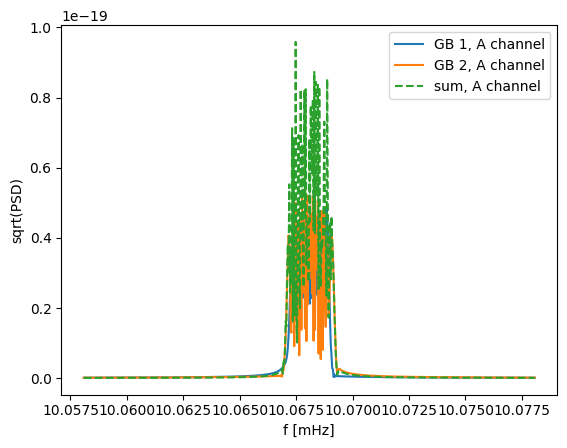

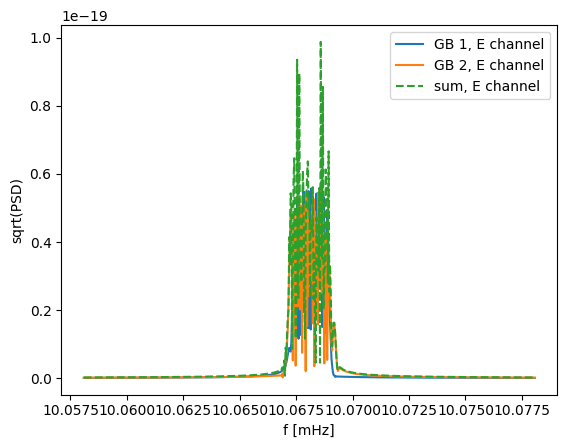

In [36]:
# choose a small window around the peak frequency
fmin = src1["Frequency"]-1e-5
fmax = src1["Frequency"]+1e-5
df = AET_data_fd.f[1] - AET_data_fd.f[0]
emin = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmin))
emax = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmax))
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.A[emin:emax])*np.sqrt(4*df),label='GB 1, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.A[emin:emax])*np.sqrt(4*df),label='GB 2, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.A[emin:emax])*np.sqrt(4*df),label='sum, A channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.E[emin:emax])*np.sqrt(4*df),label='GB 1, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.E[emin:emax])*np.sqrt(4*df),label='GB 2, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.E[emin:emax])*np.sqrt(4*df),label='sum, E channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

In [37]:
s_a = noise.psd(freq=f, option='A')
snr_a = (4.0*df) * np.sum(np.abs(AET_data_fd.A)[:]**2/s_a)
print("Computed SNR is " + str(np.sqrt(float(snr_a))))

/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in true_divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in true_divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/usr/local/lib/python3.10/dist-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in multiply
  s_oms_nu = self.psd_oms_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/usr/local/lib/python3.10/dist-packages/ldc/lis

Computed SNR is 101.71856381047239


In [38]:
likelihood(inj2.copy(),Nsrc=2,data=[data_A,data_E,data_T],GB=GB)

array(8900.73857999)

In [39]:
from eryn.ensemble import EnsembleSampler
ndim = len(inj2)
nwalkers=3*ndim
ntemps = 5
nchainlength= 15000
nburn=500

# start in a small ball around the right answer
# to initialize blind searches, could use a peak detection
theta0 = np.array([[np.random.randn(ndim)*1e-12 + inj2 for _ in range(nwalkers)] for _ in range(ntemps)])
download_results = True

if not download_results:
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool,args=(2,))
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
  tau=sampler.get_autocorr_time()['model_0']
  print(tau)
  # thin chains to make sure we have independent samples
  chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
  np.save("./chains12_22.npy",chains)
else:
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR" -O chains12_22.npy && rm -rf /tmp/cookies.txt
  chains = np.load("./chains12_22.npy")

--2023-06-26 16:40:02--  https://docs.google.com/uc?export=download&confirm=t&id=1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR
Resolving docs.google.com (docs.google.com)... 172.217.214.101, 172.217.214.113, 172.217.214.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/785gun2qc3uc35p16j4kbft0o21vrjhi/1687797600000/05374547873163544695/*/1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR?e=download&uuid=f39ef31b-7519-44fa-92cb-ffa5455714ee [following]
--2023-06-26 16:40:02--  https://doc-14-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/785gun2qc3uc35p16j4kbft0o21vrjhi/1687797600000/05374547873163544695/*/1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR?e=download&uuid=f39ef31b-7519-44fa-92cb-ffa5455714ee
Resolving doc-14-18-docs.googleusercontent.com (doc-14-18-docs.googleusercontent.com)... 172.253.119.

In [40]:
chains_burnt = chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

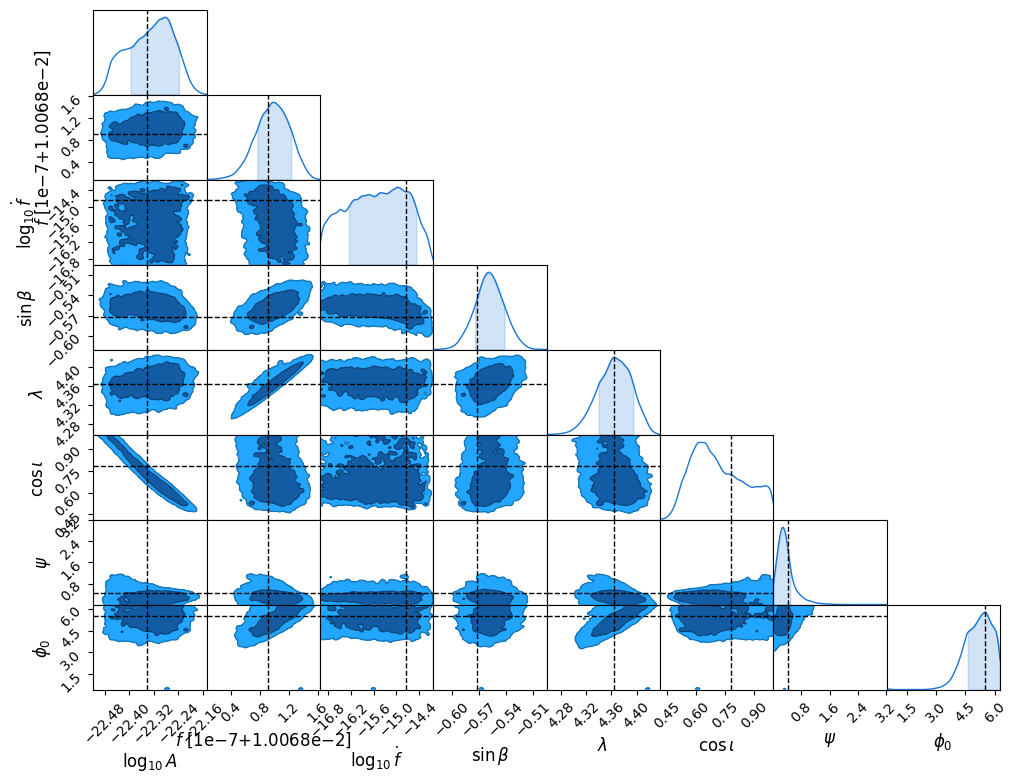

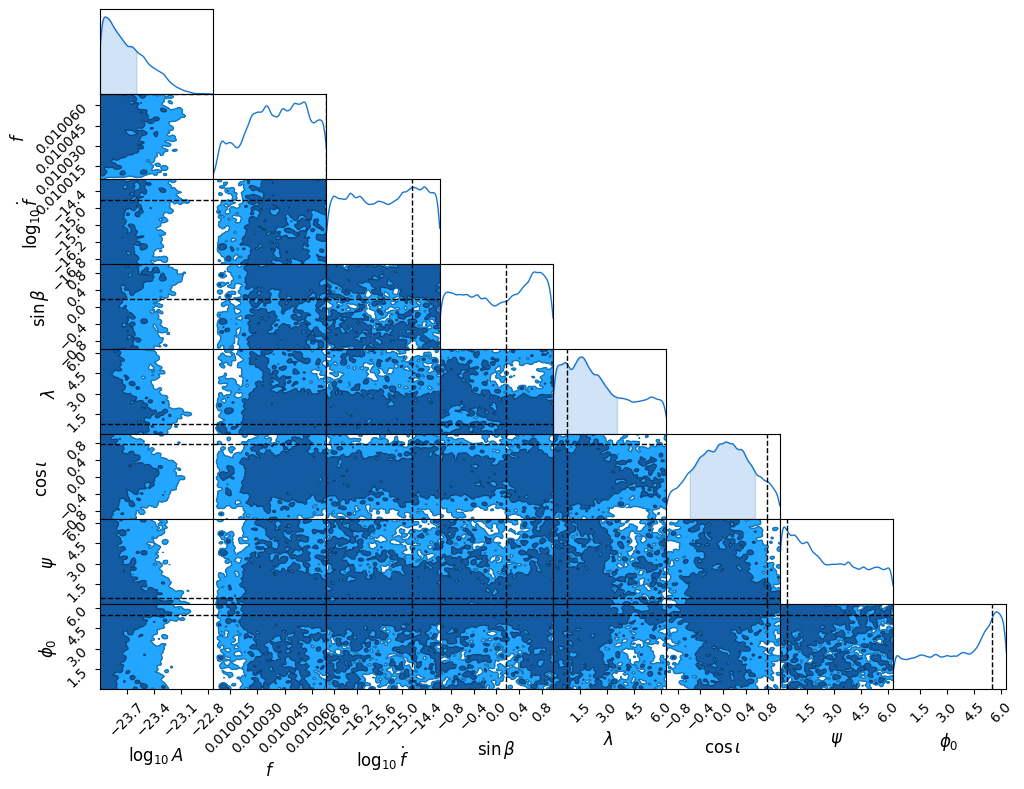

In [41]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']
truths = inj2
labels_final = labels
c.add_chain(chains_burnt[:,:8],parameters=labels_final,name='GB 1')
fig1 = c.plotter.plot(truth=truths[:8], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()
c = ChainConsumer()
c.add_chain(chains_burnt[:,8:],parameters=labels_final,name='GB 2')
fig2 = c.plotter.plot(truth=truths[8:], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()

# Next steps for understanding more LISA global fit data analysis
- [Tyson Littenberg's and Neil Cornish's Global Fit pipeline paper](https://arxiv.org/abs/2301.03673)
- Link to one of Tyson's or Neil's talks
- Blocked Gibbs sampling
- MBHB code
- Link to one of Robbie's stochastic talk